In [10]:
# === Minimal helpers for per-particle training/eval ===
import re, numpy as np, pandas as pd, torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

def ensure_sensor_energy(df: pd.DataFrame) -> pd.DataFrame:
    if "sensor_energy" in df.columns and df["sensor_energy"].apply(
        lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0
    ).all():
        return df
    layer_cols = sorted([c for c in df.columns if re.fullmatch(r"layer_\d{3}_MeV", c)],
                        key=lambda s: int(s.split("_")[1]))
    out = df.copy()
    out["sensor_energy"] = out[layer_cols].values.tolist()
    return out

def to_matrix(sensor_energy_col, max_layers=None):
    rows, L = [], 0
    for v in sensor_energy_col:
        a = np.asarray(v, np.float32).ravel()
        rows.append(a); L = max(L, a.size)
    if max_layers is not None: L = int(max_layers)
    M = np.zeros((len(rows), L), np.float32)
    for i,a in enumerate(rows):
        k = min(L, a.size)
        if k: M[i,:k] = a[:k]
    return M

def make_loaders_from_df(df, batch_size=512, val_split=0.1):
    df = ensure_sensor_energy(df)
    X = to_matrix(df["sensor_energy"])
    y = df["true_energy"].to_numpy(np.float32).reshape(-1,1)
    x_mean = X.mean(axis=0, keepdims=True).astype(np.float32)
    x_std  = (X.std(axis=0, keepdims=True) + 1e-6).astype(np.float32)
    Xz = (X - x_mean) / x_std
    Xt, yt = torch.tensor(Xz), torch.tensor(y)
    ds = TensorDataset(Xt, yt)
    n_val = int(val_split*len(ds)); n_tr = len(ds) - n_val
    tr_ds, va_ds = random_split(ds, [n_tr, n_val], generator=torch.Generator().manual_seed(42))
    return DataLoader(tr_ds, batch_size=batch_size, shuffle=True), \
           DataLoader(va_ds, batch_size=batch_size, shuffle=False), \
           {"x_mean": x_mean, "x_std": x_std}, \
           Xt.shape[1]

def build_model(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 128), nn.GELU(),
        nn.Linear(128, 64), nn.GELU(),
        nn.Linear(64, 1), nn.Softplus()  # or drop Softplus and use Linear if you prefer
    )

def relE_loss(pred, y):  # ((E_true - E_pred)^2)/E_true
    return torch.mean(((y - pred)**2) / y)

def train_one(df_train, epochs=500, batch_size=512, val_split=0.1):
    tr_loader, va_loader, scalers, input_dim = make_loaders_from_df(df_train, batch_size=batch_size, val_split=val_split)
    model = build_model(input_dim)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    best, best_state = 1e9, None
    for ep in range(1, epochs+1):
        model.train(); run=0.0
        for xb, yb in tr_loader:
            opt.zero_grad(); loss = relE_loss(model(xb), yb); loss.backward(); opt.step()
            run += loss.item()*yb.size(0)
        train_loss = run/len(tr_loader.dataset)
        model.eval(); v=0.0
        with torch.no_grad():
            for xb, yb in va_loader:
                v += relE_loss(model(xb), yb).item()*yb.size(0)
        val_loss = v/len(va_loader.dataset)
        if val_loss < best: best, best_state = val_loss, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        if ep%10==0 or ep==1: print(f"ep{ep:03d}  train={train_loss:.3f}  val={val_loss:.3f}")
    if best_state is not None: model.load_state_dict(best_state)
    return model, scalers, input_dim

def eval_one(model, scalers, input_dim, df_eval, title=""):
    df = ensure_sensor_energy(df_eval)
    df = df[(df["true_energy"]>=1)&(df["true_energy"]<=100)].reset_index(drop=True)
    M = to_matrix(df["sensor_energy"], max_layers=input_dim)
    X = (M - scalers["x_mean"]) / (scalers["x_std"] + 1e-12)
    with torch.no_grad():
        y_pred = model(torch.tensor(X)).numpy().ravel()
    y_true = df["true_energy"].to_numpy(float)
    y_base = M.sum(axis=1)/1000.0
    dnn_loss  = float(np.mean(((y_true - y_pred)**2) / y_true))
    base_loss = float(np.mean(((y_true - y_base)**2) / y_true))
    mae  = float(np.mean(np.abs(y_pred - y_true)))
    rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
    print(f"{title} DNN loss={dnn_loss:.3f} | BASE={base_loss:.3f} | MAE={mae:.3f} GeV | RMSE={rmse:.3f} GeV")


wandb: Currently logged in as: egeeroglu (egeeroglu-karlsruhe-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.03474
val_loss,0.08571


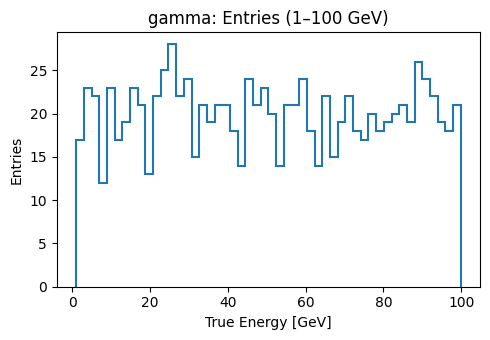

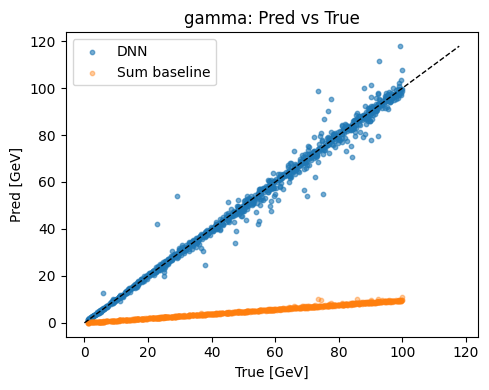

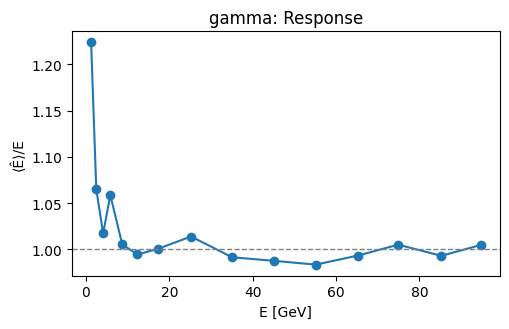

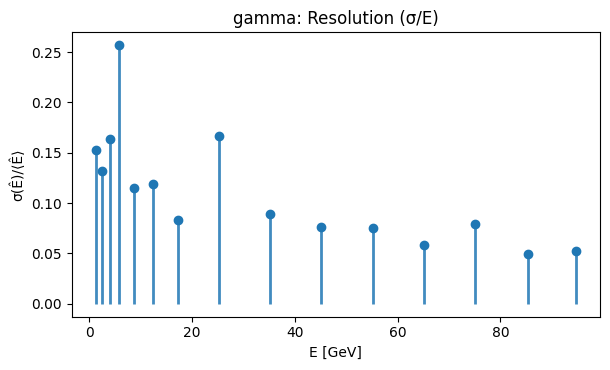

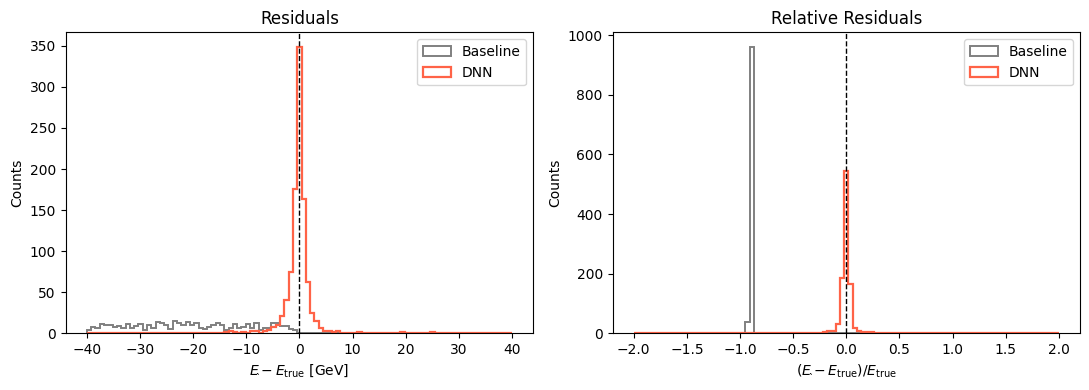

base_loss,▁
dnn_loss,▁
mae_GeV,▁
rmse_GeV,▁
base_loss,41.22609
dnn_loss,0.15939
mae_GeV,1.42098
rmse_GeV,2.90899


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.36173
val_loss,0.49969


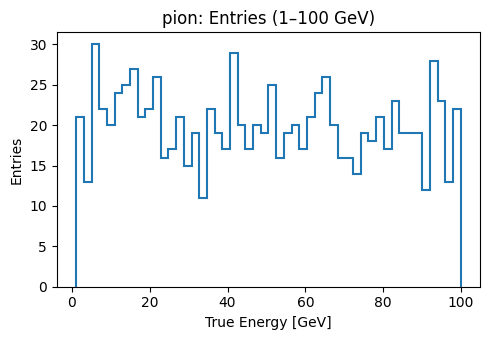

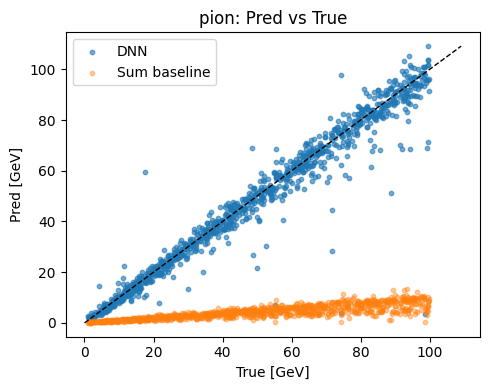

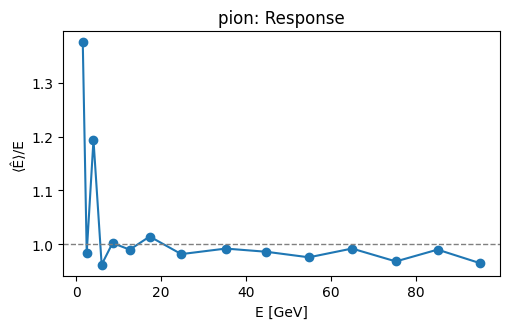

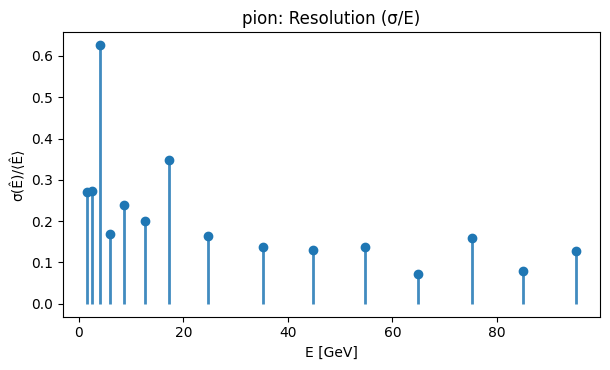

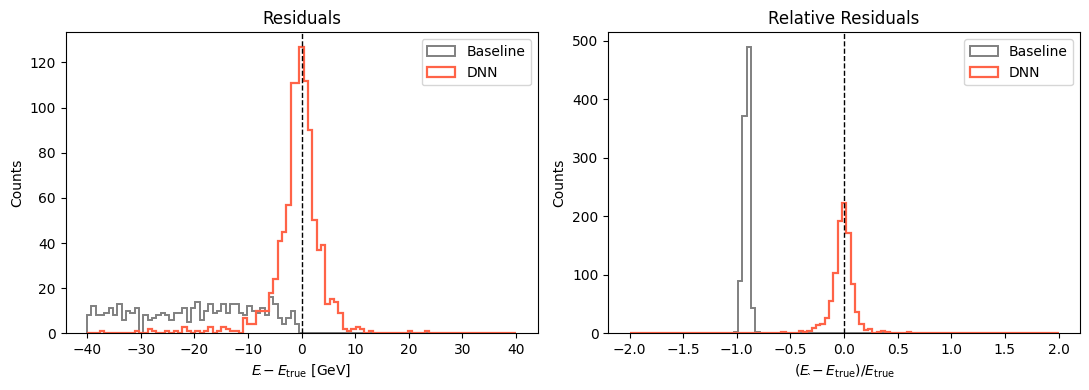

base_loss,▁
dnn_loss,▁
mae_GeV,▁
rmse_GeV,▁
base_loss,41.3137
dnn_loss,0.76166
mae_GeV,3.20673
rmse_GeV,6.51248


In [13]:
# ==== Train + Eval per particle, with all plots logged to W&B ====
import re, numpy as np, pandas as pd, torch, wandb, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# ---------- helpers ----------
def ensure_sensor_energy(df: pd.DataFrame) -> pd.DataFrame:
    if "sensor_energy" in df.columns and df["sensor_energy"].apply(
        lambda x: isinstance(x,(list,tuple,np.ndarray)) and len(x)>0
    ).all():
        return df
    layer_cols = sorted([c for c in df.columns if re.fullmatch(r"layer_\d{3}_MeV", c)],
                        key=lambda s: int(s.split("_")[1]))
    if not layer_cols:
        raise RuntimeError("No per-layer features found.")
    out = df.copy()
    out["sensor_energy"] = out[layer_cols].values.tolist()
    return out

def to_matrix(sensor_energy_col, max_layers=None):
    rows, L = [], 0
    for v in sensor_energy_col:
        a = np.asarray(v, np.float32).ravel()
        rows.append(a); L = max(L, a.size)
    if max_layers is not None: L = int(max_layers)
    M = np.zeros((len(rows), L), np.float32)
    for i,a in enumerate(rows):
        k = min(L, a.size)
        if k: M[i,:k] = a[:k]
    return M

def baseline_sum_GeV(df_or_M):
    if isinstance(df_or_M, pd.DataFrame):
        if "sensor_energy" in df_or_M.columns:
            return np.array([np.sum(x)/1000.0 for x in df_or_M["sensor_energy"]], dtype=np.float64)
        layer_cols = [c for c in df_or_M.columns if c.startswith("layer_") and c.endswith("_MeV")]
        return df_or_M[layer_cols].to_numpy(np.float64).sum(axis=1) / 1000.0
    # matrix path:
    return np.sum(df_or_M, axis=1) / 1000.0

def binned_stats(y_true, y_pred, edges):
    centers, resp, reso = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        m = (y_true >= lo) & (y_true < hi)
        if not np.any(m): continue
        yt, yp = y_true[m], y_pred[m]
        Ebar, mu, sig = float(np.mean(yt)), float(np.mean(yp)), float(np.std(yp, ddof=1))
        centers.append(Ebar)
        resp.append(mu/Ebar if Ebar>0 else np.nan)
        reso.append(sig/mu if mu>0 else np.nan)
    return np.array(centers), np.array(resp), np.array(reso)

def build_model(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 256), nn.GELU(),
        nn.Linear(256, 128), nn.GELU(),
        nn.Linear(128, 1), nn.Softplus()
    )

def relE_loss(pred, y):  # ((E_true - E_pred)^2)/E_true
    return torch.mean(((y - pred)**2) / y)

def make_loaders_from_df(df, batch_size=512, val_split=0.1):
    df = ensure_sensor_energy(df)
    X = to_matrix(df["sensor_energy"])
    y = df["true_energy"].to_numpy(np.float32).reshape(-1,1)
    x_mean = X.mean(axis=0, keepdims=True).astype(np.float32)
    x_std  = (X.std(axis=0, keepdims=True) + 1e-6).astype(np.float32)
    Xz = (X - x_mean) / x_std
    Xt, yt = torch.tensor(Xz), torch.tensor(y)
    ds = TensorDataset(Xt, yt)
    n_val = int(val_split*len(ds)); n_tr = len(ds) - n_val
    tr_ds, va_ds = random_split(ds, [n_tr, n_val], generator=torch.Generator().manual_seed(42))
    return DataLoader(tr_ds, batch_size=batch_size, shuffle=True), \
           DataLoader(va_ds, batch_size=batch_size, shuffle=False), \
           {"x_mean": x_mean, "x_std": x_std}, Xt.shape[1]

def train_one(df_train, particle, epochs=150, batch_size=512, val_split=0.1):
    tr_loader, va_loader, scalers, input_dim = make_loaders_from_df(df_train, batch_size, val_split)
    model = build_model(input_dim)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

    wandb.init(project="calo-dnn", name=f"{particle}_train_{epochs}ep",
               config={"particle":particle,"epochs":epochs,"batch_size":batch_size,
                       "arch":"256-128-1 Softplus","act":"GELU","opt":"AdamW",
                       "lr":1e-3,"wd":1e-5,"loss":"((E_true - E_pred)^2)/E_true"})

    best_val, best_state = float("inf"), None
    for ep in range(1, epochs+1):
        model.train(); total_train = 0.0
        for xb, yb in tr_loader:
            opt.zero_grad(); loss = relE_loss(model(xb), yb); loss.backward(); opt.step()
            total_train += loss.item()*xb.size(0)
        train_loss = total_train / len(tr_loader.dataset)

        model.eval(); total_val = 0.0
        with torch.no_grad():
            for xb, yb in va_loader:
                total_val += relE_loss(model(xb), yb).item()*xb.size(0)
        val_loss = total_val / len(va_loader.dataset)

        wandb.log({"epoch": ep, "train_loss": train_loss, "val_loss": val_loss})

        if val_loss < best_val:
            best_val, best_state = val_loss, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    wandb.finish()
    return model, scalers, input_dim

def eval_with_plots_and_log(model, scalers, input_dim, df_eval, particle, run_name):
    # prepare eval data
    df_ev = ensure_sensor_energy(df_eval)
    df_ev = df_ev[(df_ev["true_energy"]>=1) & (df_ev["true_energy"]<=100)].reset_index(drop=True)
    M = to_matrix(df_ev["sensor_energy"], max_layers=input_dim)
    X = (M - scalers["x_mean"]) / (scalers["x_std"] + 1e-12)
    y_true = df_ev["true_energy"].to_numpy(float)

    # predict + baseline
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X, dtype=torch.float32)).numpy().ravel()
    y_base = baseline_sum_GeV(M)

    # metrics
    dnn_loss  = float(np.mean(((y_true - y_pred)**2) / y_true))
    base_loss = float(np.mean(((y_true - y_base)**2) / y_true))
    mae  = float(np.mean(np.abs(y_pred - y_true)))
    rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))

    # plots
    # 0) entries (true energy) histogram
    plt.figure(figsize=(5,3.5))
    plt.hist(y_true, bins=50, histtype="step", lw=1.5)
    plt.xlabel("True Energy [GeV]"); plt.ylabel("Entries"); plt.title(f"{particle}: Entries (1–100 GeV)")
    plt.tight_layout(); fig_entries = plt.gcf(); plt.show()

    # 1) Pred vs True with baseline
    plt.figure(figsize=(5,4))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6, label="DNN")
    plt.scatter(y_true, y_base, s=10, alpha=0.4, label="Sum baseline")
    mx = max(y_true.max(), y_pred.max(), y_base.max()); plt.plot([0,mx],[0,mx],'k--',lw=1)
    plt.xlabel("True [GeV]"); plt.ylabel("Pred [GeV]"); plt.title(f"{particle}: Pred vs True")
    plt.legend(); plt.tight_layout(); fig_scatter = plt.gcf(); plt.show()

    # 2) Response / 3) Resolution
    edges = np.array([1,2,3,5,7,10,15,20,30,40,50,60,70,80,90,100], float)
    centers, resp, reso = binned_stats(y_true, y_pred, edges)

    plt.figure(figsize=(5.2,3.4))
    plt.plot(centers, resp, marker="o"); plt.axhline(1.0, ls="--", lw=1, color="gray")
    plt.xlabel("E [GeV]"); plt.ylabel("⟨Ê⟩/E"); plt.title(f"{particle}: Response"); plt.tight_layout()
    fig_resp = plt.gcf(); plt.show()

    plt.figure(figsize=(6.2,3.8))
    for x, y in zip(centers, reso): plt.vlines(x, 0, y, linewidth=2, alpha=0.85)
    plt.scatter(centers, reso, s=36)
    plt.xlabel("E [GeV]"); plt.ylabel("σ(Ê)/⟨Ê⟩"); plt.title(f"{particle}: Resolution (σ/E)")
    plt.tight_layout(); fig_reso = plt.gcf(); plt.show()

    # 4) Residuals (absolute & relative), DNN vs baseline
    res_dnn, res_base = (y_pred - y_true), (y_base - y_true)
    rel_res_dnn  = res_dnn / np.clip(y_true, 1e-12, None)
    rel_res_base = res_base / np.clip(y_true, 1e-12, None)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))
    bins = np.linspace(-40, 40, 100)
    ax[0].hist(res_base, bins=bins, histtype="step", lw=1.4, color="gray", label="Baseline")
    ax[0].hist(res_dnn,  bins=bins, histtype="step", lw=1.6, color="tomato", label="DNN")
    ax[0].axvline(0, color="k", ls="--", lw=1)
    ax[0].set_xlabel(r"$E_{\hat{}} - E_{\mathrm{true}}$ [GeV]"); ax[0].set_ylabel("Counts")
    ax[0].set_title("Residuals"); ax[0].legend()

    bins_rel = np.linspace(-2, 2, 100)
    ax[1].hist(rel_res_base, bins=bins_rel, histtype="step", lw=1.4, color="gray", label="Baseline")
    ax[1].hist(rel_res_dnn,  bins=bins_rel, histtype="step", lw=1.6, color="tomato", label="DNN")
    ax[1].axvline(0, color="k", ls="--", lw=1)
    ax[1].set_xlabel(r"$(E_{\hat{}} - E_{\mathrm{true}})/E_{\mathrm{true}}$"); ax[1].set_ylabel("Counts")
    ax[1].set_title("Relative Residuals"); ax[1].legend()

    plt.tight_layout(); fig_residuals = plt.gcf(); plt.show()

    # log to W&B (no prints)
    wandb.init(project="calo-dnn", name=run_name, config={"particle": particle, "eval_range":"1-100 GeV"})
    wandb.log({
        "dnn_loss": dnn_loss, "base_loss": base_loss, "mae_GeV": mae, "rmse_GeV": rmse,
        "entries": wandb.Image(fig_entries),
        "pred_vs_true": wandb.Image(fig_scatter),
        "response": wandb.Image(fig_resp),
        "resolution_peaks": wandb.Image(fig_reso),
        "residuals_compare": wandb.Image(fig_residuals),
        "resolution_table": wandb.Table(data=list(zip(centers, reso)), columns=["E_center_GeV","sigma_over_E"]),
    })
    wandb.finish()

# ---------- load data ----------
df_gamma_train = pd.read_pickle("gamma_dataset_1to120GeV.pkl")
df_gamma_eval  = pd.read_pickle("eval_gamma_1to100.pkl")
df_pion_train  = pd.read_pickle("pion_dataset_1to120GeV.pkl")
df_pion_eval   = pd.read_pickle("eval_pion_1to100.pkl")

# ---------- train & eval: gamma ----------
wandb.login()
gamma_model, gamma_scalers, gamma_in = train_one(df_gamma_train, "gamma", epochs=150, batch_size=512, val_split=0.1)
eval_with_plots_and_log(gamma_model, gamma_scalers, gamma_in, df_gamma_eval, "gamma", run_name="gamma_eval_1to100")

# ---------- train & eval: pion ----------
pion_model, pion_scalers, pion_in = train_one(df_pion_train, "pion", epochs=150, batch_size=512, val_split=0.1)
eval_with_plots_and_log(pion_model, pion_scalers, pion_in, df_pion_eval, "pion", run_name="pion_eval_1to100")
